In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

class Network(torch.nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = torch.nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = torch.nn.Linear(in_features=120, out_features=60)
        self.out = torch.nn.Linear(in_features=60, out_features=10)
        
    def forward(self,t):
        # 1. input layer
        t = t
        # 2. hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size=2, stride=2)
        
        # 3. hidden conv layer 2
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size=2, stride=2)
        
        # 4. linear layer1
        t = t.reshape(-1,12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        
        # 5. linear layer 2
        t = self.fc2(t)
        t = F.relu(t)
        
        # 6. output layer
        t = self.out(t)
#         t = F.softmax()
        
        return t

def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

network = Network()

train_loader = torch.utils.data.DataLoader(train_set,batch_size=100)
optimizer = torch.optim.Adam(network.parameters(),lr=0.01)


for epoch in range(1):
    
    total_loss = 0
    total_correct = 0
    
    for batch in train_loader:
        images,labels = batch

        preds = network(images)
        loss = F.cross_entropy(preds,labels)   #计算loss

        optimizer.zero_grad()
        loss.backward()    #计算梯度
        optimizer.step()   #更新权重

        total_loss += loss.item()
        total_correct += get_num_correct(preds,labels)

    print('epochs:',epoch,'total_loss:',total_loss,'total_correct:',total_correct)

epochs: 0 total_loss: 345.71286526322365 total_correct: 46730


## 用pytorch得到混淆矩阵

In [2]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [3]:
with torch.no_grad():
    loader = torch.utils.data.DataLoader(train_set,batch_size=10000)
    all_preds = get_all_preds(network,loader)

In [4]:
stacked = torch.stack((all_preds.argmax(dim=1),train_set.targets),dim=1)
stacked.shape

torch.Size([60000, 2])

In [5]:
cmt = torch.zeros((10,10),dtype=torch.int32)

In [6]:
for p in stacked:
    tl,pl = p.tolist()
    cmt[tl,pl] = cmt[tl,pl]+1

In [7]:
cmt

tensor([[5293,   30,   61,  269,   11,    2, 1521,    0,   26,    0],
        [   5, 5732,    8,   26,    6,    1,    7,    0,    3,    1],
        [  59,    6, 3503,   22,  131,    1,  369,    0,   16,    0],
        [ 210,  193,   49, 5380,  260,   10,  165,    0,   82,    6],
        [  24,   16, 1399,  209, 4988,    0,  644,    1,   66,    2],
        [   7,    2,    0,    1,    1, 5587,    1,  130,   83,   30],
        [ 385,   21,  973,   92,  596,    0, 3253,    0,  189,    0],
        [   0,    0,    1,    0,    0,  299,    0, 5803,   15,  642],
        [  17,    0,    6,    1,    7,    1,   40,    0, 5520,    4],
        [   0,    0,    0,    0,    0,   99,    0,   66,    0, 5315]],
       dtype=torch.int32)

## 使用scipy得到混淆矩阵

In [12]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from resources.plotcm import plot_confusion_matrix

In [13]:
cm = confusion_matrix(all_preds.argmax(dim=1), train_set.targets)
cm

array([[5293,   30,   61,  269,   11,    2, 1521,    0,   26,    0],
       [   5, 5732,    8,   26,    6,    1,    7,    0,    3,    1],
       [  59,    6, 3503,   22,  131,    1,  369,    0,   16,    0],
       [ 210,  193,   49, 5380,  260,   10,  165,    0,   82,    6],
       [  24,   16, 1399,  209, 4988,    0,  644,    1,   66,    2],
       [   7,    2,    0,    1,    1, 5587,    1,  130,   83,   30],
       [ 385,   21,  973,   92,  596,    0, 3253,    0,  189,    0],
       [   0,    0,    1,    0,    0,  299,    0, 5803,   15,  642],
       [  17,    0,    6,    1,    7,    1,   40,    0, 5520,    4],
       [   0,    0,    0,    0,    0,   99,    0,   66,    0, 5315]],
      dtype=int64)

Confusion matrix, without normalization
[[5293   30   61  269   11    2 1521    0   26    0]
 [   5 5732    8   26    6    1    7    0    3    1]
 [  59    6 3503   22  131    1  369    0   16    0]
 [ 210  193   49 5380  260   10  165    0   82    6]
 [  24   16 1399  209 4988    0  644    1   66    2]
 [   7    2    0    1    1 5587    1  130   83   30]
 [ 385   21  973   92  596    0 3253    0  189    0]
 [   0    0    1    0    0  299    0 5803   15  642]
 [  17    0    6    1    7    1   40    0 5520    4]
 [   0    0    0    0    0   99    0   66    0 5315]]


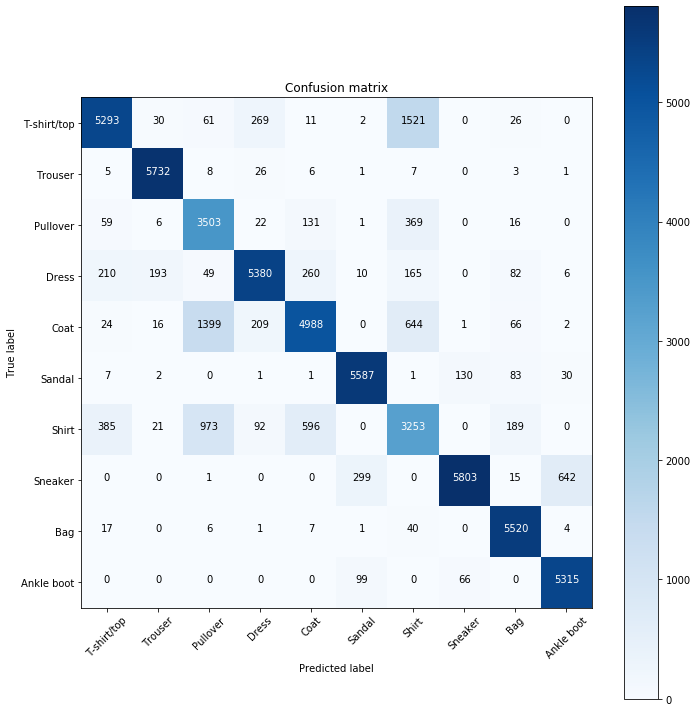

In [14]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm,train_set.classes)